In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime, timezone
import json
import fitsio
import pandas as pd
import time
import pickle
import re



%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything
from survey_ops.utils.script_utils import load_raw_data_to_dataframe


In [3]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load and cut data from fits file, save as .json

In [4]:
data_json_fn = '../data/decam-exposures-20251211.json'
data_fits_fn = '../data/decam-exposures-20251211.fits'
data_json_full_fn = '../data/decam-exposures-20251211-full.json'


In [5]:
from survey_ops.utils import ephemerides
from tqdm import tqdm

In [6]:
df = load_raw_data_to_dataframe(data_fits_fn, data_json_fn)

In [7]:
binning_method='healpix'
nside=16
bin_space='radec'
specific_years=None
specific_months = None
specific_days=None
specific_years=[2017]
specific_months=[1]
specific_days=[3]
include_default_features=True
include_bin_features=False
do_z_score_norm=False
do_cyclical_norm=True
do_max_norm=True
do_inverse_airmass=True
new_method=True

train_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    specific_months=specific_months,
    specific_days=specific_days,
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
    do_max_norm=do_max_norm,
    do_inverse_airmass=do_inverse_airmass,
    calculate_action_mask=False,
    new_method=new_method
)

Calculating sun and moon ra/dec and az/el: 100%|█| 40/40 [00:00<00:00, 1102.73it
Calculating zenith states: 100%|█████████████████| 1/1 [00:00<00:00, 802.12it/s]


In [8]:
train_dataset_old = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    specific_months=specific_months,
    specific_days=specific_days,
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
    do_max_norm=do_max_norm,
    do_inverse_airmass=do_inverse_airmass,
    calculate_action_mask=False,
    new_method=False
)

Calculating sun and moon ra/dec and az/el: 100%|█| 40/40 [00:00<00:00, 915.78it/
Calculating zenith states: 100%|█████████████████| 1/1 [00:00<00:00, 633.68it/s]


In [9]:
train_dataset.num_transitions

39

In [14]:
train_dataset.state_feature_names

['ra_cos',
 'ra_sin',
 'dec',
 'az_cos',
 'az_sin',
 'el',
 'airmass',
 'ha_cos',
 'ha_sin',
 'sun_ra_cos',
 'sun_ra_sin',
 'sun_dec',
 'sun_az_cos',
 'sun_az_sin',
 'sun_el',
 'moon_ra_cos',
 'moon_ra_sin',
 'moon_dec',
 'moon_az_cos',
 'moon_az_sin',
 'moon_el',
 'time_fraction_since_start']

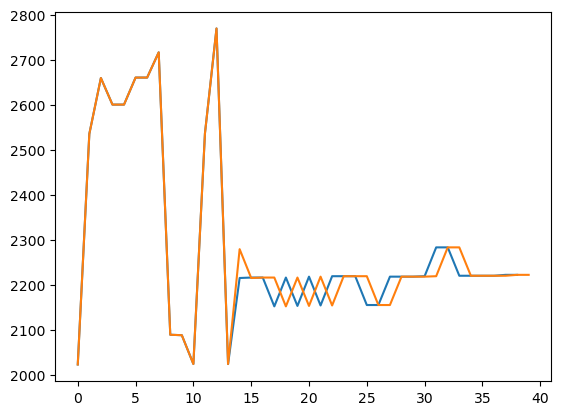

In [17]:
plt.plot(train_dataset.actions)
plt.plot(train_dataset_old.actions)


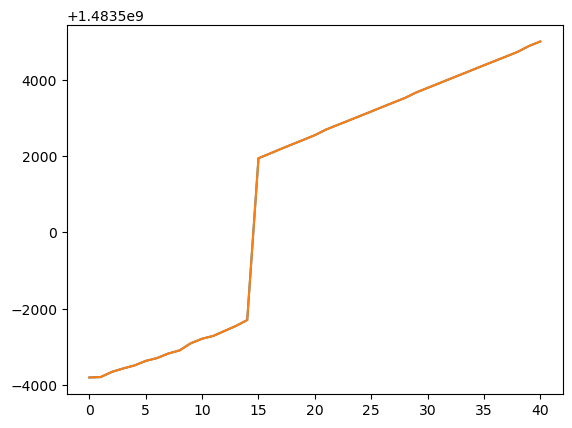

In [13]:
plt.plot(train_dataset._df.timestamp.values)
plt.plot(train_dataset_old._df.timestamp.values)

# Instantiate the offline dataset choosing binning method (healpix vs uniform_grid)

In [30]:
binning_method='healpix'
nside=16
bin_space='radec'
specific_years=None
specific_months = None
specific_days=None
specific_years=[2016]
# specific_months=[9]
# specific_days=[15]
include_default_features=True
include_bin_features=False
do_z_score_norm=False
do_cyclical_norm=True
do_max_norm=True
do_inverse_airmass=True

In [31]:
train_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    specific_months=specific_months,
    specific_days=specific_days,
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
    do_max_norm=do_max_norm,
    do_inverse_airmass=do_inverse_airmass,
    calculate_action_mask=False
)

Calculating zenith states: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 672.52it/s]


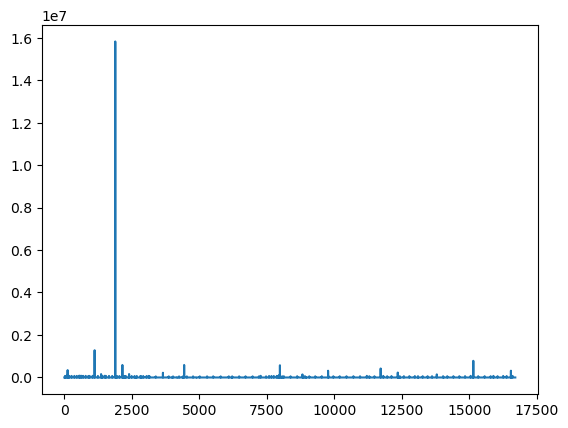

In [44]:
plt.plot(np.diff(train_dataset._df.timestamp))

In [8]:
trainloader, valloader = train_dataset.get_dataloader(512, num_workers=10, pin_memory=True, random_seed=10, return_train_and_val=True)


In [20]:
trainloader.dataset.dataset[trainloader.dataset.indices]

(tensor([[ 0.8868,  0.4622, -0.1803,  ..., -0.0088, -0.6056,  0.5924],
         [ 0.7241,  0.6897, -0.0351,  ...,  0.7810,  0.2319,  0.7641],
         [ 0.9422, -0.3351, -0.5748,  ..., -0.9094, -0.2445,  0.2408],
         ...,
         [ 0.4766,  0.8791, -0.1906,  ...,  0.7141,  0.3113,  0.7252],
         [ 0.9544, -0.2986, -0.4508,  ...,  0.9949, -0.5292,  0.1134],
         [ 0.7710,  0.6369, -0.5626,  ...,  0.9986,  0.0032,  0.9476]]),
 tensor([1957, 2856, 2757,  ..., 2027, 2588, 2714], dtype=torch.int32),
 tensor([0.4907, 0.5467, 0.2383,  ..., 0.1682, 0.2710, 0.3505]),
 tensor([[ 0.8706,  0.4920, -0.1803,  ...,  0.0056, -0.6056,  0.5960],
         [ 0.7396,  0.6731, -0.6888,  ...,  0.7728,  0.2396,  0.7713],
         [ 0.9422, -0.3351, -0.5748,  ..., -0.9071, -0.2486,  0.2443],
         ...,
         [ 0.4287,  0.9034, -0.2028,  ...,  0.7092,  0.3146,  0.7294],
         [ 0.9426, -0.3340, -0.4846,  ...,  0.9954, -0.5247,  0.1172],
         [ 0.7114,  0.7028, -0.5400,  ...,  0.9983, 

In [14]:
trainloader.dataset.dataset.states.shape

torch.Size([16589, 22])

In [13]:
valloader.dataset.dataset.states.shape

torch.Size([16589, 22])

In [11]:
import seaborn as sns

In [12]:
train_dataset._df.keys()

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'night', 'timestamp',
       'sun_ra', 'sun_dec', 'sun_az', 'sun_el', 'moon_ra', 'moon_dec',
       'moon_az', 'moon_el', 'time_fraction_since_start', 'ra_cos', 'ra_sin',
       'az_cos', 'az_sin', 'ha_cos', 'ha_sin', 'sun_ra_cos', 'sun_ra_sin',
       'sun_az_cos', 'sun_az_sin', 'moon_ra_cos', 'moon_ra_sin', 'moon_az_cos',
       'moon_az_sin', 'el', 'bin', 'field_id'],
      dtype='object')

In [13]:
train_dataset.base_feature_names

['ra',
 'dec',
 'az',
 'el',
 'airmass',
 'ha',
 'sun_ra',
 'sun_dec',
 'sun_az',
 'sun_el',
 'moon_ra',
 'moon_dec',
 'moon_az',
 'moon_el',
 'time_fraction_since_start']

In [10]:
for night, subdf in train_dataset._df.groupby('night'):
    diff_in_exptime = np.diff(subdf['exptime'].values)
    plt.plot(diff_in_exptime, marker='o')
    plt.title(night)
    print(f"mean {np.mean(diff_in_exptime)}, std {np.std(diff_in_exptime)}, max {np.max(diff_in_exptime)}, min {np.min(diff_in_exptime)})
    break

SyntaxError: unterminated string literal (detected at line 5) (2317673773.py, line 5)

In [44]:
# train_dataset._df.loc[~train_dataset._df['object'].isin(['DES wide hex', 'DES survey hex'])]['object'].unique()

In [45]:
# masks = ~train_dataset._df['object'].str.contains('DES wide hex') 
# masks &= ~train_dataset._df['object'].str.contains('DES survey hex') 
# masks &= ~train_dataset._df['object'].str.contains('zenith') 
# # masks &= ~train_dataset._df['object'].str.contains('DES wide hex') 
# potential_lo = train_dataset._df['object'][masks].unique()

In [167]:
night

Timestamp('2019-01-09 00:00:00')

In [168]:
train_dataset._df['night'] = pd.Timestamp('2019-01-09 00:00:00')

In [55]:
a.dayofyear

243

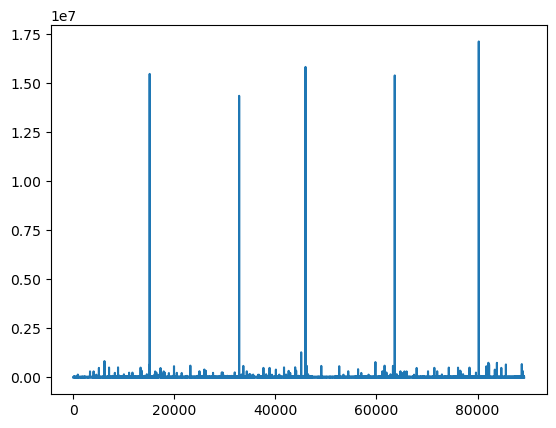

In [24]:
time_between_obs = np.diff(train_dataset._df['timestamp'])
plt.plot(time_between_obs)

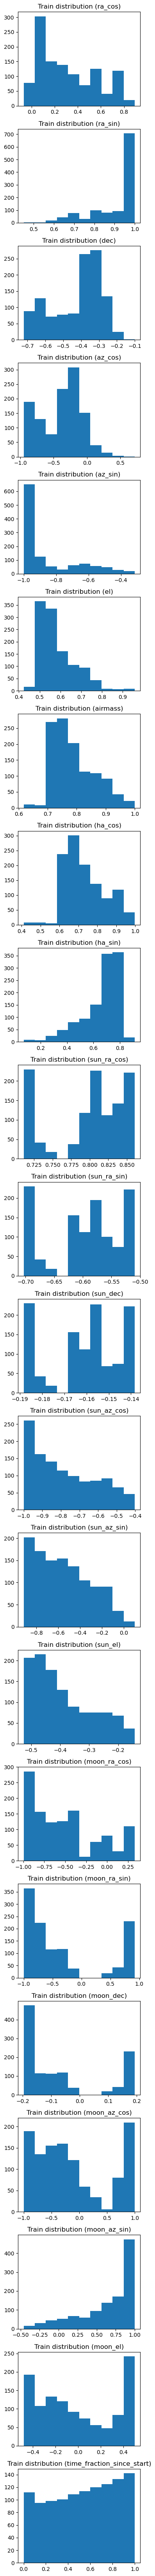

In [7]:

fig, axs = plt.subplots(len(train_dataset.state_feature_names), figsize=(4, len(train_dataset.state_feature_names)*3))
for i, feat_row in enumerate(train_dataset.next_states.T):
    axs[i].hist(feat_row)
    axs[i].set_title(f"Train distribution ({train_dataset.state_feature_names[i]})")
fig.tight_layout()

# Visualize dataset in az, el and ra, dec

In [10]:
obj_names, counts = np.unique(train_dataset._df.object, return_counts=True)

Text(0, 0.5, 'Number of fields')

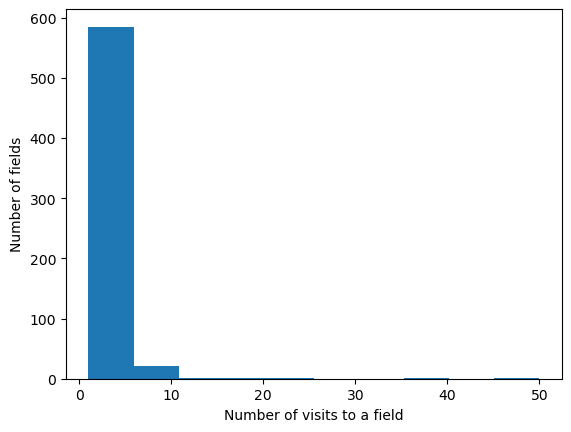

In [11]:
plt.hist(counts)
plt.xlabel('Number of visits to a field')
plt.ylabel('Number of fields')

Text(0.5, 0, 'Number of observations in a night')

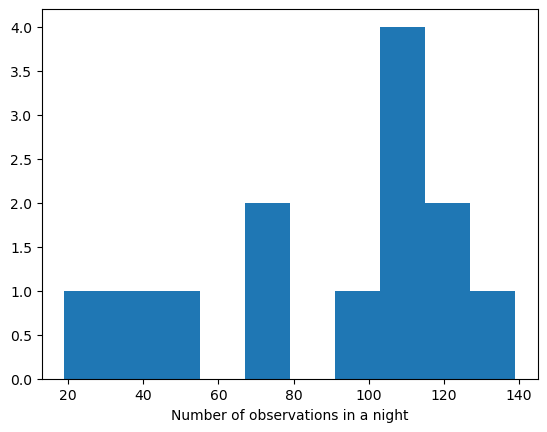

In [13]:
plt.hist(train_dataset.n_obs_per_night)
plt.xlabel('Number of observations in a night')

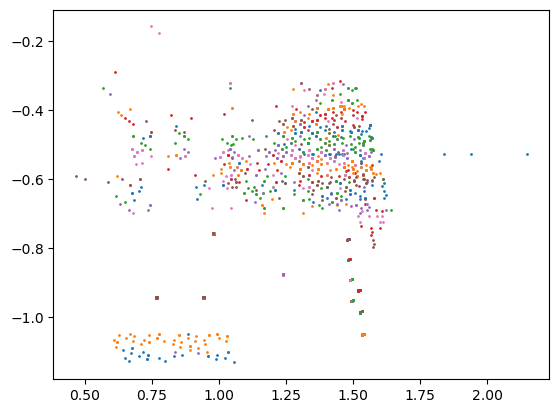

In [14]:
colors = [f'C{i}' for i in range(7)]
for i, (bin_id, g) in enumerate(train_dataset._df.groupby('bin')):
    plt.scatter(g.ra, g.dec, label=bin_id, color=colors[i%len(colors)], s=1)